In [72]:
from lanlab import Text,Batch,Sequential
from lanlab import load,save
from lanlab import GPT35_0301,GPT35_0613 #Version of the paper
from lanlab import Module
from lanlab import set_number_workers

import os
import numpy as np

set_number_workers(10)

### Load the Datasets

In [73]:
from lanlab import load
question_data = load("inputs/cf").repeat(1,axis=1) #Each question is asked once but you can increase it


#For a quick test, we can limit the number of questions
np.random.shuffle(question_data.array)
question_data.array = question_data.array[:100] #Limit the number of questions to 100


question_data.shape

(100, 1)

### Make the pipelines

In [74]:
from lanlab import BatchedModule
class AutoCorrect(BatchedModule):
    def _run(self, seq):
        text = seq[-1]['text']
        if 'a)' in text:
            return Text('a')
        elif 'b)' in text:
            return Text('b')
        else:
            return Text('None')

In [75]:
model = GPT35_0613().configure(max_tokens=16)

vanilla_pipeline = Sequential(model,AutoCorrect())
reasoning_pipeline = Sequential("Mathematically speaking, the most probable answer is (",model,AutoCorrect())

pipelines = [vanilla_pipeline,reasoning_pipeline]

### Get the results

In [76]:
#Get results
names = ['vanilla','reasoning']
results = []
for name,pipeline in zip(names,pipelines):
    out = pipeline(question_data,os.path.join('data','cf',model.name,name)) #If the result is already computed it will load it instead of recomputing it. Either delete the file at the specified address of change the save address if you want to recompute the result (cf tutorial.ipynb for more details)
    results.append(out)

cf_vanilla,cf_reasoning = results

### Correct the results

In [77]:
#Plot results
def correct(cf):
    correct_bill = 0
    correct_linda = 0
    nb_bill = 0
    nb_linda = 0
    for q in range(cf.shape[0]):
        if 'a' in cf[q,0][-1]['text'] and cf[q,0][0]['info']['order'] == 1:
            if cf[q,0][0]['info']['type'] == 'bill':
                correct_bill += 1
            elif cf[q,0][0]['info']['type'] == 'linda':
                correct_linda += 1
        elif 'b' in cf[q,0][-1]['text'] and cf[q,0][0]['info']['order'] == 0:
            if cf[q,0][0]['info']['type'] == 'bill':
                correct_bill += 1
            elif cf[q,0][0]['info']['type'] == 'linda':
                correct_linda += 1
        if cf[q,0][0]['info']['type'] == 'bill':
            nb_bill += 1
        elif cf[q,0][0]['info']['type'] == 'linda':
            nb_linda += 1
    return correct_bill/nb_bill,correct_linda/nb_linda

### Plot the results

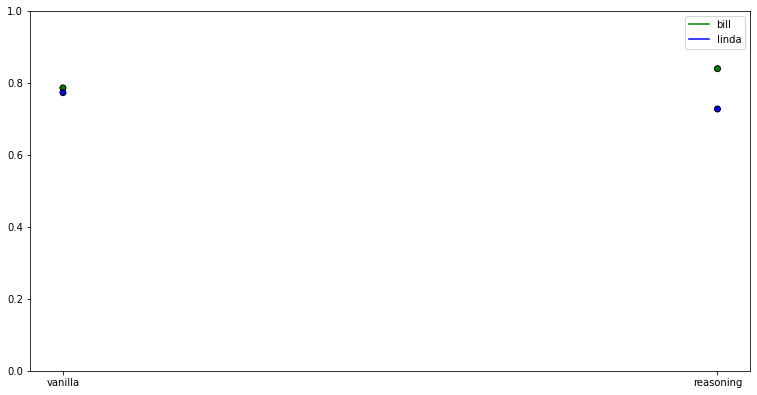

In [78]:
#Plot in bars
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])

#Plot for each condition (vanilla, example, reasoning) plot the linda and the bill bar next to each other. Leave a space between the conditions.
vanilla_correct = correct(cf_vanilla)
reasoning_correct = correct(cf_reasoning)

ax.scatter([0,0,1,1],vanilla_correct + reasoning_correct,c=['g','b']*2,marker='o',edgecolors='black')
ax.plot([],[],c='g',label='bill')
ax.plot([],[],c='b',label='linda')
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['vanilla','reasoning'])
ax.legend()
ax.set_ylim(0,1)
plt.show()